## Paqueterías

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from semopy import Model, Optimizer, semplot
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from IPython.display import display

import warnings 
warnings.filterwarnings('ignore')

---

# Proyecto Final
**Laboratorio de Análisis Financiero y de Diseño de Indicadores**

**Integrantes del equipo:**
- Luis Eduardo Jiménez del Muro
- Lenin Adair Quezada Gómez
- José Armando Melchor Soto
- Edgar Alfonso Ramos Gómez

**Fecha: 26/11/2024**

## Carga de Datos 

In [2]:
reparaciones = pd.read_csv('reparaciones.csv')
reparaciones = reparaciones[['CLIENTE', 'COHORT', 'DESCRIPCION FALLA', 'INGRESO', 'FECHA REPARACION', 'CLUSTER', 'SIMILITUD COSENO']]

clientes = pd.read_csv('data/CLIENTES.csv', encoding='latin1')
clientes = clientes[['CLIENTE', 'NOMBRES']]

reparaciones

,CLIENTE,COHORT,DESCRIPCION FALLA,INGRESO,FECHA REPARACION,CLUSTER,SIMILITUD COSENO
0,2,2017-11-22,revision general tndr cambio del panel de cont...,1820.0,29/11/2018,Impresora Laser,0.298307
1,2,2017-11-22,imprime negro tn mantenimiento iva,480.0,30/11/2018,Impresora Tinta,0.391361
2,2,2017-11-22,rev gral cartucho toner reparacion traccion de...,1030.0,02/01/2019,Impresora Laser,0.508475
3,2,2017-11-22,rev gral sin toner con cable de energia bue...,530.0,29/11/2018,Impresora Laser,0.493519
4,2,2017-11-22,rev gral sin toner cambio de contacto del ca...,480.0,29/11/2018,Impresora Laser,0.448675
...,...,...,...,...,...,...,...
9295,1835,2024-09-13,en el area del impime obscuro en doble cara ta...,2815.0,20/09/2024,Sistemas,0.325016
9296,1837,2024-09-13,no escanea no saca copias marca papel atascado...,3532.0,30/09/2024,Sistemas,0.275756
9297,1843,2024-09-24,marcaba error de fusor y luego error de escane...,4790.0,30/09/2024,Impresora Laser,0.458887
9298,1841,2024-09-20,arruga las hojas y se atora cambio de filmin...,2575.0,26/09/2024,Otros,0.408079


## Limpieza de los datos

En esta sección principalmente se observará la distribución de las similitudes coseno y establecer un threshold para eliminar la clasificación imprecisa que pudo tener el modelo de embedding vectors.

### Número de fallas por cluster antes de limpieza

Text(0, 0.5, 'CANTIDAD')

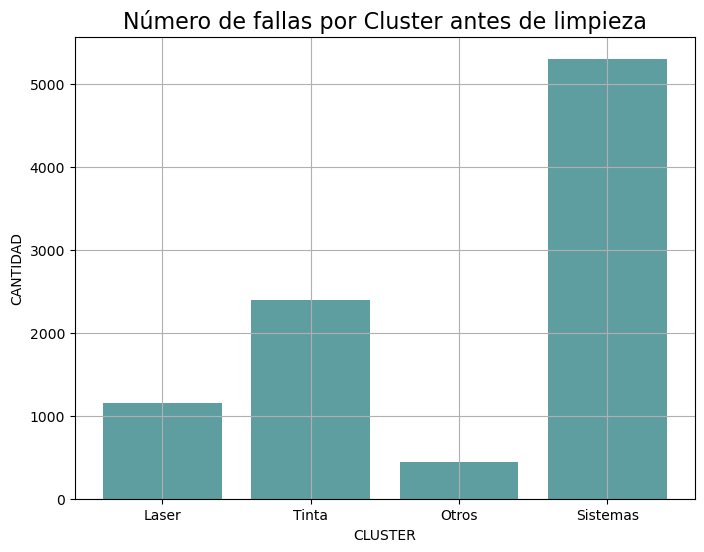

In [3]:
plt.figure(figsize=(8,6))
plt.grid()
plt.bar(['Laser', 'Tinta', 'Otros', 'Sistemas'], reparaciones.groupby('CLUSTER')['CLUSTER'].count(), color='cadetblue')
plt.title('Número de fallas por Cluster antes de limpieza', fontsize=16)
plt.xlabel('CLUSTER')
plt.ylabel('CANTIDAD')

### Distribución de las similitudes coseno

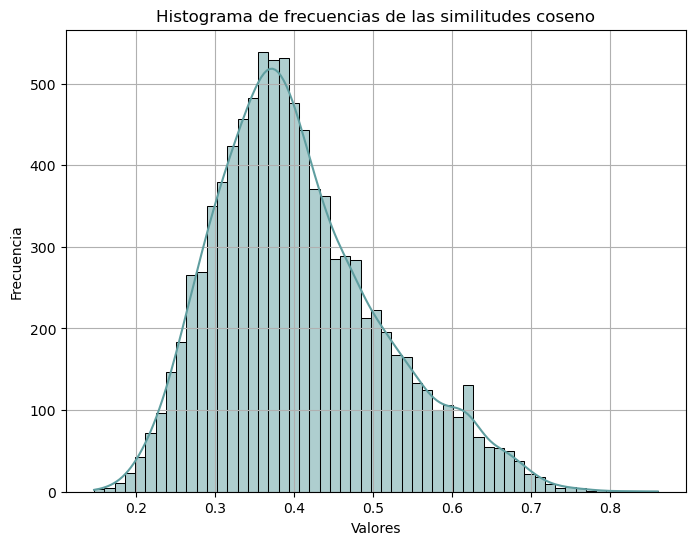

In [4]:
plt.figure(figsize=(8,6))
sns.histplot(reparaciones['SIMILITUD COSENO'], kde=True, color='cadetblue')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.title('Histograma de frecuencias de las similitudes coseno')
plt.grid()

### Establecimiento del threshold

#### Percentil 0.05 de la distribución

In [5]:
threshold = reparaciones['SIMILITUD COSENO'].quantile(0.05)
threshold

0.25578981100000003

Observamos que el 5% de las similitudes coseno mas bajas se encuentran de 0.2557 para abajo. Sin embargo, nosotros, decidimos penalizar un poco más y decidimos eliminar todas las que se encuentren por dabajo de 0.27 de similitud.

### Número de fallas fuera del threshold

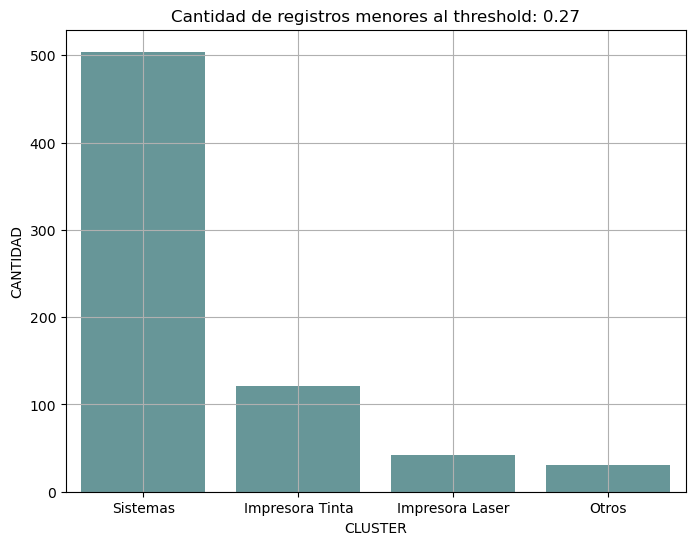

In [6]:
df_filtrado = reparaciones[reparaciones['SIMILITUD COSENO'] < 0.27]

conteo_clusters = df_filtrado['CLUSTER'].value_counts().reset_index()
conteo_clusters.columns = ['CLUSTER', 'cantidad']

plt.figure(figsize=(8,6))
sns.barplot(data=conteo_clusters, x='CLUSTER', y='cantidad', color = 'cadetblue')
plt.xlabel('CLUSTER')
plt.ylabel('CANTIDAD')
plt.title('Cantidad de registros menores al threshold: 0.27')
plt.grid()

In [7]:
reparaciones_thresholded = reparaciones[reparaciones['SIMILITUD COSENO'] >= 0.27].reset_index()
reparaciones_thresholded = reparaciones_thresholded.drop(columns='index')
reparaciones_thresholded

,CLIENTE,COHORT,DESCRIPCION FALLA,INGRESO,FECHA REPARACION,CLUSTER,SIMILITUD COSENO
0,2,2017-11-22,revision general tndr cambio del panel de cont...,1820.0,29/11/2018,Impresora Laser,0.298307
1,2,2017-11-22,imprime negro tn mantenimiento iva,480.0,30/11/2018,Impresora Tinta,0.391361
2,2,2017-11-22,rev gral cartucho toner reparacion traccion de...,1030.0,02/01/2019,Impresora Laser,0.508475
3,2,2017-11-22,rev gral sin toner con cable de energia bue...,530.0,29/11/2018,Impresora Laser,0.493519
4,2,2017-11-22,rev gral sin toner cambio de contacto del ca...,480.0,29/11/2018,Impresora Laser,0.448675
...,...,...,...,...,...,...,...
8597,1835,2024-09-13,en el area del impime obscuro en doble cara ta...,2815.0,20/09/2024,Sistemas,0.325016
8598,1837,2024-09-13,no escanea no saca copias marca papel atascado...,3532.0,30/09/2024,Sistemas,0.275756
8599,1843,2024-09-24,marcaba error de fusor y luego error de escane...,4790.0,30/09/2024,Impresora Laser,0.458887
8600,1841,2024-09-20,arruga las hojas y se atora cambio de filmin...,2575.0,26/09/2024,Otros,0.408079


Text(0, 0.5, 'CANTIDAD')

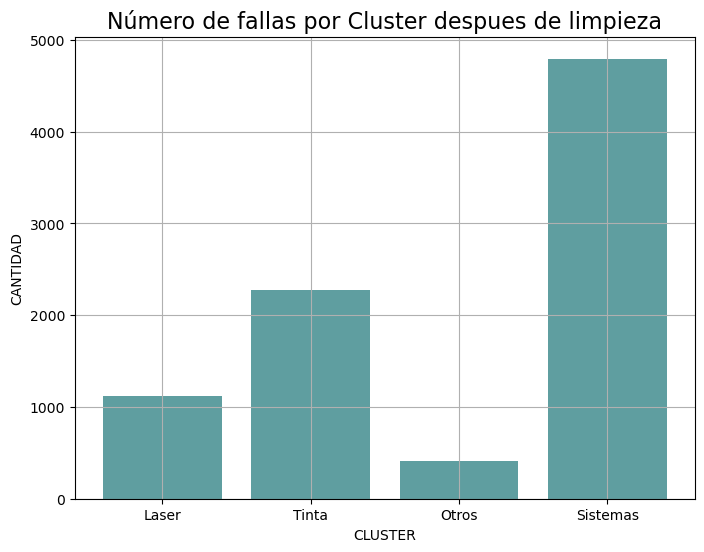

In [8]:
plt.figure(figsize=(8,6))
plt.grid()
plt.bar(['Laser', 'Tinta', 'Otros', 'Sistemas'], reparaciones_thresholded.groupby('CLUSTER')['CLUSTER'].count(), color='cadetblue')
plt.title('Número de fallas por Cluster despues de limpieza', fontsize=16)
plt.xlabel('CLUSTER')
plt.ylabel('CANTIDAD')

In [9]:
reparaciones = reparaciones_thresholded[['CLIENTE', 'COHORT', 'DESCRIPCION FALLA', 'INGRESO', 'FECHA REPARACION', 'CLUSTER']]

## Exploración de Datos 

In [10]:
reparaciones

,CLIENTE,COHORT,DESCRIPCION FALLA,INGRESO,FECHA REPARACION,CLUSTER
0,2,2017-11-22,revision general tndr cambio del panel de cont...,1820.0,29/11/2018,Impresora Laser
1,2,2017-11-22,imprime negro tn mantenimiento iva,480.0,30/11/2018,Impresora Tinta
2,2,2017-11-22,rev gral cartucho toner reparacion traccion de...,1030.0,02/01/2019,Impresora Laser
3,2,2017-11-22,rev gral sin toner con cable de energia bue...,530.0,29/11/2018,Impresora Laser
4,2,2017-11-22,rev gral sin toner cambio de contacto del ca...,480.0,29/11/2018,Impresora Laser
...,...,...,...,...,...,...
8597,1835,2024-09-13,en el area del impime obscuro en doble cara ta...,2815.0,20/09/2024,Sistemas
8598,1837,2024-09-13,no escanea no saca copias marca papel atascado...,3532.0,30/09/2024,Sistemas
8599,1843,2024-09-24,marcaba error de fusor y luego error de escane...,4790.0,30/09/2024,Impresora Laser
8600,1841,2024-09-20,arruga las hojas y se atora cambio de filmin...,2575.0,26/09/2024,Otros


In [11]:
reparaciones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8602 entries, 0 to 8601
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CLIENTE            8602 non-null   int64  
 1   COHORT             8602 non-null   object 
 2   DESCRIPCION FALLA  8602 non-null   object 
 3   INGRESO            8602 non-null   float64
 4   FECHA REPARACION   8602 non-null   object 
 5   CLUSTER            8602 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 403.3+ KB


### Corregir las fechas que están escrita con '-' y cambiarlas por '/' para realizar la conversión a DateTime

In [12]:
reparaciones['FECHA REPARACION'] = reparaciones['FECHA REPARACION'].str.replace('-', '/')
reparaciones['COHORT'] = reparaciones['COHORT'].str.replace('-', '/')

reparaciones['FECHA REPARACION'] = pd.to_datetime(reparaciones['FECHA REPARACION'], dayfirst=True, errors='coerce')
reparaciones['COHORT'] = pd.to_datetime(reparaciones['COHORT'], dayfirst=True, errors='coerce')

current_date = datetime.now()
reparaciones.loc[reparaciones['FECHA REPARACION'] > current_date, 'FECHA REPARACION'] = pd.NaT
reparaciones.loc[reparaciones['COHORT'] > current_date, 'COHORT'] = pd.NaT

reparaciones = reparaciones.dropna(subset='FECHA REPARACION')
reparaciones = reparaciones.dropna(subset='COHORT')

reparaciones.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8593 entries, 0 to 8601
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   CLIENTE            8593 non-null   int64         
 1   COHORT             8593 non-null   datetime64[ns]
 2   DESCRIPCION FALLA  8593 non-null   object        
 3   INGRESO            8593 non-null   float64       
 4   FECHA REPARACION   8593 non-null   datetime64[ns]
 5   CLUSTER            8593 non-null   object        
dtypes: datetime64[ns](2), float64(1), int64(1), object(2)
memory usage: 469.9+ KB


### Identificar primer ticket por cliente. 

In [13]:
reparaciones_sorted = reparaciones.sort_values(by=['CLIENTE', 'FECHA REPARACION'])
first_ticket_df = reparaciones_sorted.groupby('CLIENTE').first().reset_index()
first_ticket_df = first_ticket_df[['CLIENTE', 'CLUSTER', 'INGRESO']]
first_ticket_df.head()

,CLIENTE,CLUSTER,INGRESO
0,2,Impresora Laser,1820.0
1,3,Sistemas,360.0
2,4,Sistemas,300.0
3,5,Sistemas,480.0
4,6,Sistemas,500.0


## Análisis y cálculo del KPI

### Customer Lifetime Value (24 Meses)

In [14]:
snapshot_date = reparaciones['FECHA REPARACION'].max()
snapshot_date

Timestamp('2024-10-18 00:00:00')

In [15]:
reparaciones['FECHA REPARACION'].min()

Timestamp('2017-12-04 00:00:00')

In [16]:
reparaciones['CUSTOMER_TENURE'] = (snapshot_date.year - reparaciones['FECHA REPARACION'].dt.year)*12 + (
    snapshot_date.month - reparaciones['FECHA REPARACION'].dt.month)

reparaciones['CUSTOMER_TENURE_ON_TRANSACTION'] = (
    reparaciones['FECHA REPARACION'].dt.year - reparaciones['COHORT'].dt.year)*12 + (
    reparaciones['FECHA REPARACION'].dt.month - reparaciones['COHORT'].dt.month
)

cltv_24_months = reparaciones[
    (reparaciones['CUSTOMER_TENURE'] > 24) &
    (reparaciones['CUSTOMER_TENURE_ON_TRANSACTION'] <= 24)
].groupby('CLIENTE')['INGRESO'].sum().reset_index()
cltv_24_months = cltv_24_months.rename(columns={'INGRESO':'LTV_24_MESES'})

cltv_nombres = cltv_24_months.merge(clientes, on='CLIENTE', how='inner') # Para poder observar los nombres de los clientes

cltv_24_months.head()

,CLIENTE,LTV_24_MESES
0,2,10200.0
1,3,31575.0
2,4,142495.8
3,5,32372.0
4,6,13021.0


## Visualización de las variables relacionadas. 

### LTV por cohort

Text(0, 0.5, 'LTV')

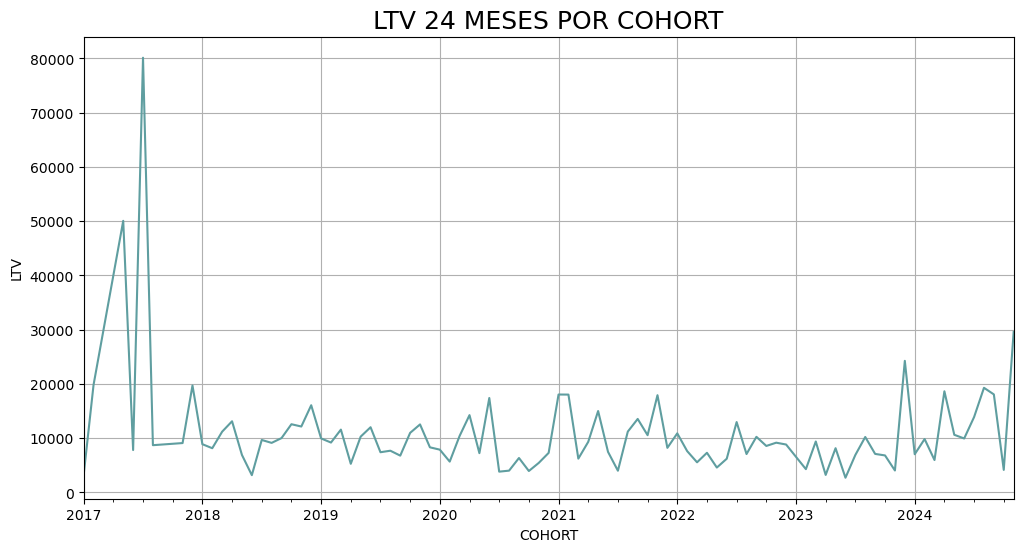

In [17]:
reparaciones_ltv = reparaciones.merge(cltv_24_months, on='CLIENTE', how='inner')
reparaciones_cohort_m = reparaciones_ltv[['CLIENTE', 'COHORT', 'LTV_24_MESES']]
reparaciones_cohort_m['COHORT'] = pd.to_datetime(reparaciones['COHORT'], errors='coerce').dt.to_period('M')
reparaciones_cohort_m = reparaciones_cohort_m.drop_duplicates().reset_index(drop=True)
reparaciones_cohort_m = reparaciones_cohort_m.sort_values('COHORT').dropna()

plt.figure(figsize=(12,6))
reparaciones_cohort_m.groupby('COHORT')['LTV_24_MESES'].mean().plot(color='cadetblue')
plt.title('LTV 24 MESES POR COHORT', fontsize=18)
plt.grid()
plt.xlabel('COHORT')
plt.ylabel('LTV')

- El principal objetivo de la empresa es mejorar el LifeTime Value de sus clientes. Lo que podemos ver en la gráfica, es que a lo largo de los años que llevan operando no ha habido ningun tipo de mejora en esto.
- Los clientes que entraron en 2018 le han dado el mismo LifeTime Value que los que entraron en 2022.

## Predicción del Customer Lifetime Value

Para esta regresión lineal se utilizará el primer ticket de cada cliente. Las variables que se tienen es la cantidad de dinero que ingresó a la empresa en su primer ticket y el sector al que se dirigía su reparación.

In [18]:
first_ticket_df['LTV'] = cltv_24_months['LTV_24_MESES']
df_regresion = first_ticket_df.dropna()
df_regresion

,CLIENTE,CLUSTER,INGRESO,LTV
0,2,Impresora Laser,1820.0,10200.0
1,3,Sistemas,360.0,31575.0
2,4,Sistemas,300.0,142495.8
3,5,Sistemas,480.0,32372.0
4,6,Sistemas,500.0,13021.0
...,...,...,...,...
1221,1467,Impresora Tinta,2100.0,1240.0
1222,1470,Sistemas,6631.9,2890.0
1223,1471,Sistemas,11200.0,1064.0
1224,1472,Sistemas,850.0,2610.0


#### Creación de variables dummies para la variable categórica Cluster.

In [19]:
categorical_features = ['CLUSTER']
numerical_features = ['INGRESO', 'LTV']

data_encoded = pd.get_dummies(df_regresion[['CLIENTE']+categorical_features], 
                              columns=categorical_features, 
                              drop_first=False)

df_to_model = df_regresion[['CLIENTE']+numerical_features].merge(data_encoded, on='CLIENTE')

df_to_model

,CLIENTE,INGRESO,LTV,CLUSTER_Impresora Laser,CLUSTER_Impresora Tinta,CLUSTER_Otros,CLUSTER_Sistemas
0,2,1820.0,10200.0,1,0,0,0
1,3,360.0,31575.0,0,0,0,1
2,4,300.0,142495.8,0,0,0,1
3,5,480.0,32372.0,0,0,0,1
4,6,500.0,13021.0,0,0,0,1
...,...,...,...,...,...,...,...
1221,1467,2100.0,1240.0,0,1,0,0
1222,1470,6631.9,2890.0,0,0,0,1
1223,1471,11200.0,1064.0,0,0,0,1
1224,1472,850.0,2610.0,0,0,0,1


#### Regresión lineal con todas las variables 

In [20]:
x = ['INGRESO', 'CLUSTER_Impresora Laser', 'CLUSTER_Impresora Tinta', 'CLUSTER_Otros', 'CLUSTER_Sistemas']
y = ['LTV']


X = sm.add_constant(df_to_model[x])

model = sm.OLS(df_to_model[y], X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    LTV   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.158
Date:                Mon, 18 Nov 2024   Prob (F-statistic):             0.0716
Time:                        14:57:16   Log-Likelihood:                -13501.
No. Observations:                1226   AIC:                         2.701e+04
Df Residuals:                    1221   BIC:                         2.704e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    6

Eliminamos el Cluster de impresora de Tinta de la regresión, dado que su p-value indica que no es significativa para el modelo.

#### Regresión lineal sin Impresora Tinta

In [21]:
x = ['INGRESO', 'CLUSTER_Impresora Laser', 'CLUSTER_Otros', 'CLUSTER_Sistemas']
y = ['LTV']


X = sm.add_constant(df_to_model[x])

model = sm.OLS(df_to_model[y], X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    LTV   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     2.158
Date:                Mon, 18 Nov 2024   Prob (F-statistic):             0.0716
Time:                        14:57:16   Log-Likelihood:                -13501.
No. Observations:                1226   AIC:                         2.701e+04
Df Residuals:                    1221   BIC:                         2.704e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    6

Eliminamos el Cluster de sistemas de la regresión, dado que su p-value indica que no es significativo para el modelo.

#### Regresión lineal sin Impresora Tinta y sin Sistemas

In [22]:
x = ['INGRESO', 'CLUSTER_Impresora Laser', 'CLUSTER_Otros']
y = ['LTV']


X = sm.add_constant(df_to_model[x])

model = sm.OLS(df_to_model[y], X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    LTV   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.850
Date:                Mon, 18 Nov 2024   Prob (F-statistic):             0.0364
Time:                        14:57:16   Log-Likelihood:                -13501.
No. Observations:                1226   AIC:                         2.701e+04
Df Residuals:                    1222   BIC:                         2.703e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    6

Eliminamos el Cluster de impresora láser de la regresión, dado que su p-value indica que no es significativo para el modelo.

#### Regresión lineal sin Impresora Tinta, sin Sistemas y sin Láser

In [23]:
x = ['INGRESO', 'CLUSTER_Otros']
y = ['LTV']


X = sm.add_constant(df_to_model[x])

model = sm.OLS(df_to_model[y], X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    LTV   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     3.426
Date:                Mon, 18 Nov 2024   Prob (F-statistic):             0.0328
Time:                        14:57:16   Log-Likelihood:                -13502.
No. Observations:                1226   AIC:                         2.701e+04
Df Residuals:                    1223   BIC:                         2.702e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          6939.5079    481.161     14.422

Eliminamos el Cluster de Otros de la regresión, dado que su p-value indica que no es significativo para el modelo.

#### Regresión lineal únicamente con Ingreso

In [24]:
x = ['INGRESO']
y = ['LTV']


X = sm.add_constant(df_to_model[x])

model = sm.OLS(df_to_model[y], X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                    LTV   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     3.528
Date:                Mon, 18 Nov 2024   Prob (F-statistic):             0.0606
Time:                        14:57:16   Log-Likelihood:                -13503.
No. Observations:                1226   AIC:                         2.701e+04
Df Residuals:                    1224   BIC:                         2.702e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7118.0915    471.507     15.096      0.0

Eliminamos los ingresos de la regresión, dado que su p-value indica que no es significativo para el modelo.

### Conclusiones de la regresión

- Ninguna de las variables que tienen los datos de la empresa son significativas para la predicción del LifeTime Value de sus clientes.
- Comenzar a registrar nuevos datos que se relacionen con los objetivos de la empresa.
- Si se quiere realizar un análisis para la toma de decisiones de la empresa, no podemos encontrar datos que den soporte estadístico a las decisiones.

## Variable latente: La confianza del cliente.

Para medir la confianza del cliente utilizaremos 2 variables. En primer lugar, el número de veces que ha regresado el cliente y por último el ingreso que le ha dado a la empresa.

In [25]:
retorno_clientes = reparaciones.groupby('CLIENTE')['CLIENTE'].count()
ingreso_clientes = reparaciones.groupby('CLIENTE')['INGRESO'].sum()

confianza = pd.DataFrame()
confianza['Retorno'] = retorno_clientes
confianza['Ingreso_Total'] = ingreso_clientes
confianza = confianza.reset_index()
confianza.head()

,CLIENTE,Retorno,Ingreso_Total
0,2,6,10200.0
1,3,36,57913.5
2,4,172,208777.0
3,5,73,102255.0
4,6,13,14941.0


### Estandarizar los datos para el modelo SEM

In [26]:
df_for_scaler = confianza[['Retorno', 'Ingreso_Total']] 

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_for_scaler[['Retorno', 'Ingreso_Total']])

df_scaled = pd.DataFrame(df_scaled, columns = confianza.columns[-2:])
df_scaled.head()

,Retorno,Ingreso_Total
0,0.020393,0.000654
1,1.804099,1.847008
2,9.890235,7.684926
3,4.004004,3.562878
4,0.436591,0.184115


### Creación del Modelo

In [27]:
model_desc = """
# Latent Variables
Confianza =~ Retorno + Ingreso_Total
"""

mod = Model(model_desc)
res_opt = mod.fit(df_scaled)
estimates = mod.inspect()

estimates

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,Retorno,~,Confianza,1.000000,-,-,-
1,Ingreso_Total,~,Confianza,0.988293,0.010792,91.578769,0.0
2,Confianza,~~,Confianza,0.926630,0.026871,34.484495,0.0
3,Ingreso_Total,~~,Ingreso_Total,0.095198,0.010418,9.13819,0.0
4,Retorno,~~,Retorno,0.073608,0.010291,7.15268,0.0


### Gráfico de trayectorías 

In [28]:
g = semplot(mod, 'pd.png')

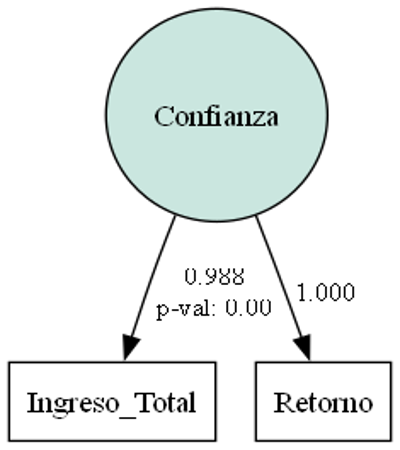

In [29]:
img = Image.open("pd.png")
img_resized = img.resize((400, 450))
display(img_resized)

### Cálculo de la Confianza del cliente 

In [30]:
df_scaled['Cliente'] = confianza['CLIENTE']
df_scaled = df_scaled.set_index('Cliente').reset_index()
df_scaled

,Cliente,Retorno,Ingreso_Total
0,2,0.020393,0.000654
1,3,1.804099,1.847008
2,4,9.890235,7.684926
3,5,4.004004,3.562878
4,6,0.436591,0.184115
...,...,...,...
1514,1845,-0.276891,-0.370834
1515,1847,-0.276891,-0.306830
1516,1848,-0.276891,-0.329816
1517,1850,-0.276891,-0.301954


In [31]:
confianza_factors = [1, 0.988]      

confianza_var = ['Retorno', 'Ingreso_Total']

def calculate_latent_values(df, factors, var):
    resultado = pd.DataFrame()
    for i in range(len(factors)):
        resultado[var[i]] =  df.iloc[:, i] * factors[i]
    resultado['Latent Value'] = resultado.sum(axis=1)
    resultado = resultado['Latent Value']
    return resultado

confianza_prediccion = calculate_latent_values(df_scaled[confianza_var], confianza_factors, confianza_var)
results = pd.DataFrame()
results[['Cliente', 'Retorno', 'Ingreso Total']] = df_scaled
results['Confianza'] = confianza_prediccion
results.head()

,Cliente,Retorno,Ingreso Total,Confianza
0,2,0.020393,0.000654,0.021039
1,3,1.804099,1.847008,3.628944
2,4,9.890235,7.684926,17.482942
3,5,4.004004,3.562878,7.524127
4,6,0.436591,0.184115,0.618497


In [32]:
results_sorted = results.sort_values('Confianza', ascending=False).reset_index()
results_sorted = results_sorted.drop(columns=['index'])

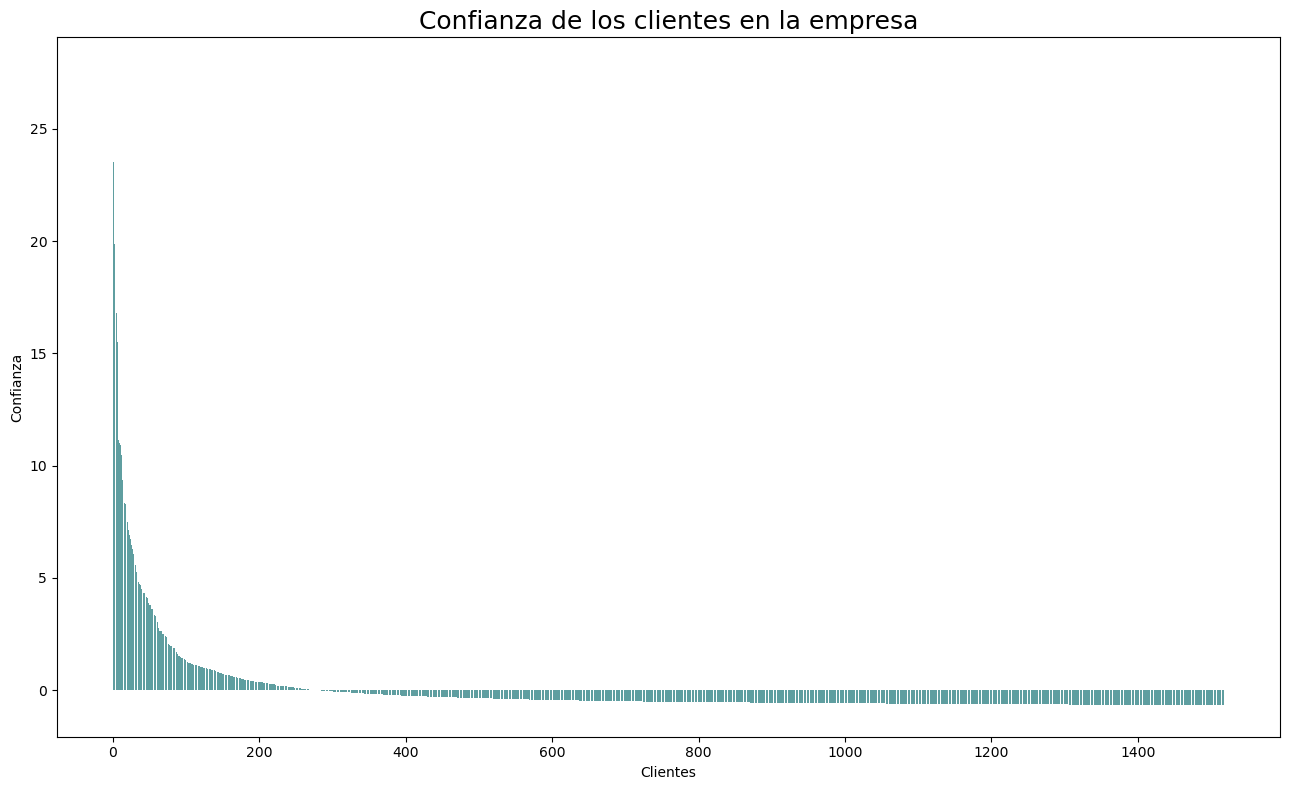

In [37]:
plt.figure(figsize=(13,8))
plt.bar(results_sorted.index, results_sorted['Confianza'], color='cadetblue')
plt.title('Confianza de los clientes en la empresa', fontsize=18)
plt.xlabel('Clientes')
plt.ylabel('Confianza')
plt.tight_layout()

Observamos que los clientes que se encuentran en el primer 5% de la gráfica con clientes que tienen mucha confianza en la empresa. Por lo que sería importante identificarlos para que la empresa esté consciente de ello y se considere tener un trato especial hacia ellos, dado que, al haber definido la confianza como las veces que regresan y su ingreso total, esto significa que esos son los clientes que mas veces regresan y mas dinero ingresan.

### Percentil 95% de la confianza de los clientes

In [34]:
threshold_confianza = results_sorted['Confianza'].quantile(0.95)
threshold_confianza

2.058130495334776

### Clientes por encima del threshold de confianza

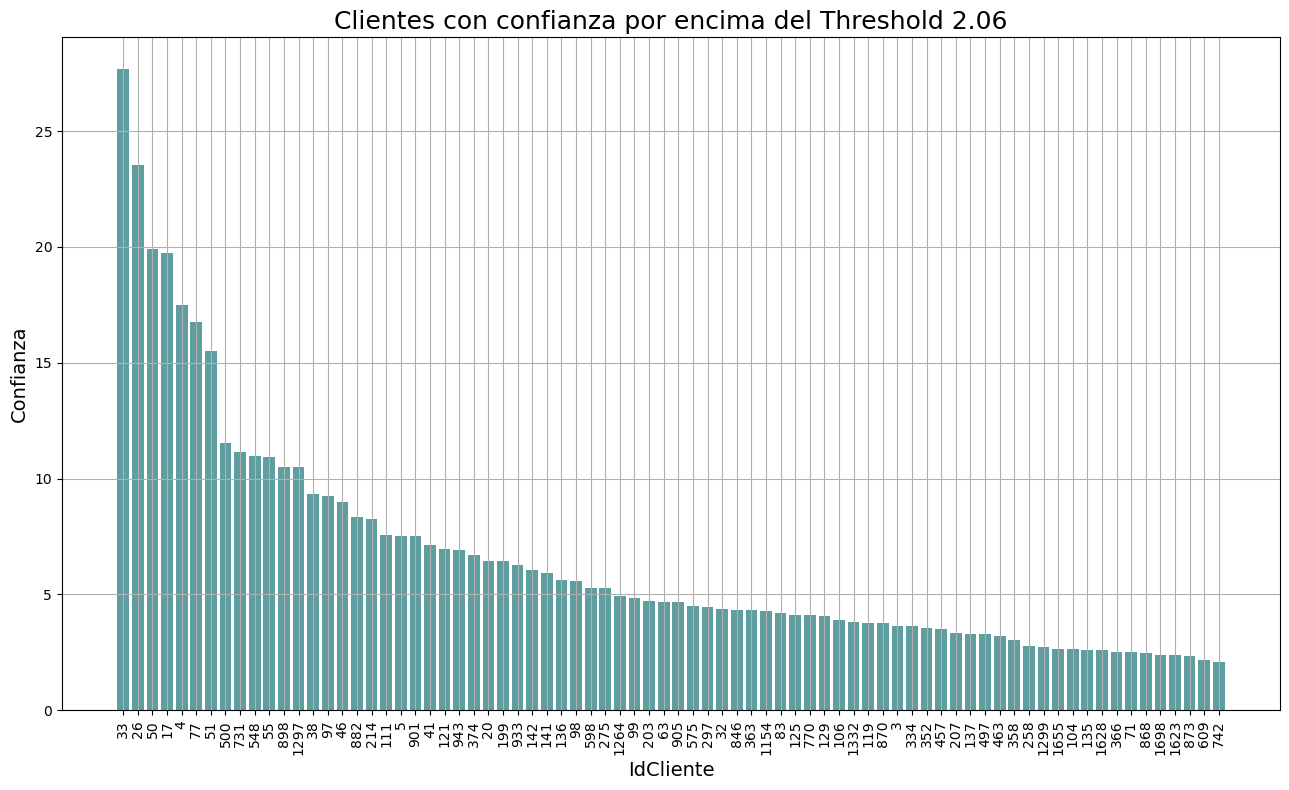

In [38]:
clientes_mayor_confianza = results_sorted[results_sorted['Confianza'] > threshold_confianza]

plt.figure(figsize=(13,8))
plt.bar(clientes_mayor_confianza.index, clientes_mayor_confianza['Confianza'], color='cadetblue', tick_label=clientes_mayor_confianza['Cliente'])
plt.title(f'Clientes con confianza por encima del Threshold {threshold_confianza:.3}', fontsize=18)
plt.xlabel('IdCliente', fontsize=14)
plt.ylabel('Confianza', fontsize=14)
plt.xticks(rotation=90)
plt.grid()
plt.tight_layout()